In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

In [2]:
train_df = pd.read_csv('PM_train.txt',sep=' ',header=None) # the values are in txt file so they should be separated by a space to distinguish what the values are
test_df = pd.read_csv('PM_test.txt',sep=' ',header=None)

In [3]:
train_df.dropna(axis=1, inplace = True) # checking columns and not creating new df
test_df.dropna(axis=1, inplace = True) # checking columns and not creating new df
column_names = ['ID','Cycle','Setting1','Setting2','Setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10'
               ,'s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
train_df.columns = column_names
test_df.columns = column_names

In [4]:
train_df = train_df.drop(['s1','s5','s6','s16','s18','s19'],axis=1)
train_df

,ID,Cycle,Setting1,Setting2,Setting3,s2,s3,s4,s7,s8,s9,s10,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [7]:
# Function to calculate metrics
def calculate_metrics(df, method, y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    df.loc[method] = [mae, mse, rmse]

# Function to calculate cross validation
def calculate_cross_validation_scores (df, model, method, X, y):
    my_cv = 20
    mae = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=my_cv).mean()
    mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=my_cv).mean()
    rmse = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=my_cv).mean()
    df.loc[method] = [mae, mse, rmse]

In [8]:
#RUL
max_cycle_per_id = train_df.groupby('ID')['Cycle'].max()
train_df['RUL'] = max_cycle_per_id[train_df['ID']].values - train_df['Cycle']
RUL_column = train_df['RUL']
train_df.drop(columns=['RUL'],inplace=True)
new_index = train_df.columns.get_loc('Cycle') + 1
train_df.insert(loc=new_index, column='RUL', value=RUL_column)

In [9]:
#Within
W1 = 30
train_df['Failure_Within_W1'] = np.where(train_df['RUL'] <= W1, 1, 0 )

In [10]:
#RUL-Test
max_cycle_per_id = test_df.groupby('ID')['Cycle'].max()
test_df['RUL'] = max_cycle_per_id[test_df['ID']].values - test_df['Cycle']
RUL_column = test_df['RUL']
test_df.drop(columns=['RUL'],inplace=True)
new_index = test_df.columns.get_loc('Cycle') + 1
test_df.insert(loc=new_index, column='RUL', value=RUL_column)

In [11]:
#Within-Test
W1 = 30
test_df['Failure_Within_W1'] = np.where(test_df['RUL'] <= W1, 1, 0 )

In [12]:
train_df

,ID,Cycle,RUL,Setting1,Setting2,Setting3,s2,s3,s4,s7,...,s10,s11,s12,s13,s14,s15,s17,s20,s21,Failure_Within_W1
0,1,1,191,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,...,1.3,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,0
1,1,2,190,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,...,1.3,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0
2,1,3,189,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,...,1.3,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0
3,1,4,188,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,...,1.3,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0
4,1,5,187,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,...,1.3,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,4,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,...,1.3,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,1
20627,100,197,3,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,...,1.3,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,1
20628,100,198,2,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,...,1.3,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,1
20629,100,199,1,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,...,1.3,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [13]:
#Normalizing-Train
train_df['Cycle_Norm'] = train_df['Cycle']
normalize_cols = train_df.columns.difference(['ID','Cycle','RUL','Failure_Within_W1'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[normalize_cols]), 
                             columns=normalize_cols, 
                             index=train_df.index)
join_df = train_df[['ID','Cycle','RUL','Failure_Within_W1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
Cycle_Norm_column = train_df['Cycle_Norm']
train_df.drop(columns=['Cycle_Norm'],inplace=True)
new_index = train_df.columns.get_loc('RUL') + 1 
train_df.insert(loc=new_index, column='Cycle_Norm', value=Cycle_Norm_column)

In [14]:
#Normalizing-Test
test_df['Cycle_Norm'] = test_df['Cycle']
normalize_cols = test_df.columns.difference(['ID','Cycle','RUL','Failure_Within_W1'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(test_df[normalize_cols]), 
                             columns=normalize_cols, 
                             index=test_df.index)
join_df = test_df[['ID','Cycle','RUL','Failure_Within_W1']].join(norm_test_df)
test_df = join_df.reindex(columns = test_df.columns)
Cycle_Norm_column = test_df['Cycle_Norm']
test_df.drop(columns=['Cycle_Norm'],inplace=True)
new_index = test_df.columns.get_loc('RUL') + 1 
test_df.insert(loc=new_index, column='Cycle_Norm', value=Cycle_Norm_column)

In [15]:
#Dropping
X = train_df.drop('RUL',axis=1)
y = train_df['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#Dataframe for Errors
error_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'R2'], index = ['Decision Tree Regression', 'Random Forest Regression','Support Vector Regression','XGBoost'])
cv_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE'], index = ['Decision Tree Regression', 'Random Forest Regression','Support Vector Regression','XGBoost'])

In [17]:
num_data_points = train_df.shape[0]
print("Number of data points:", num_data_points)

Number of data points: 20631


In [18]:
#Random Forest
regressor = RandomForestRegressor(n_estimators=300, random_state=42) # medium dataset size 
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

y_test_list = list(y_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

error_df.loc['Random Forest Regression'] = [mae, mse, rmse, r2]

print(f"Mean Absolute Error =",mae)
print(f"Mean Squared Error =",mse)
print(f"Root Mean Squared Error =",rmse)
print(f"R2 =",r2)

Mean Absolute Error = 10.620416767627818
Mean Squared Error = 259.44227648816735
Root Mean Squared Error = 16.10721194025109
R2 = 0.9432142896740765


In [19]:
calculate_cross_validation_scores (cv_df, regressor,method, X, y)
display(cv_df)

NameError: name 'method' is not defined

In [ ]:
calculate_cross_validation_scores (cv_df, regressor,method, X, y)
display(cv_df)

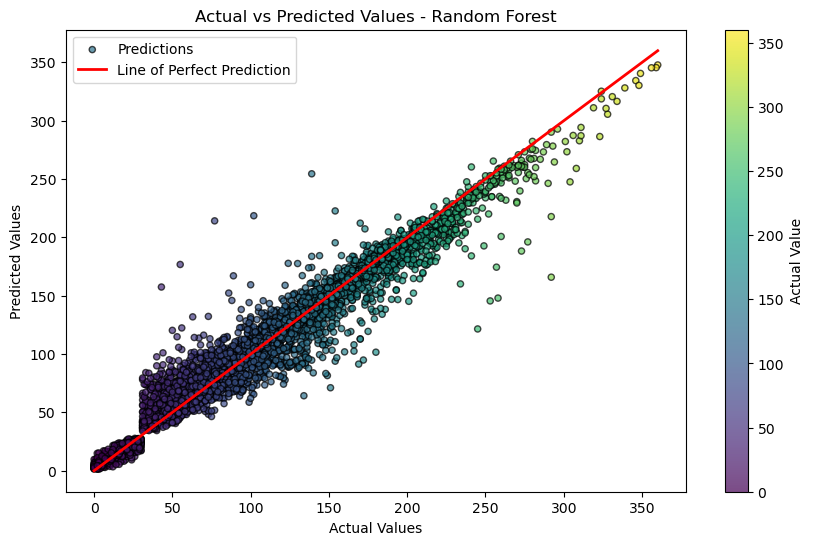

In [30]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(y_test, y_pred, c=y_test, cmap='viridis', marker='o', edgecolor='k', alpha=0.7, s=20, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label="Line of Perfect Prediction")
plt.colorbar(sc, label='Actual Value')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values - Random Forest")
plt.legend()
plt.show()

/Users/ursulasalwa/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 92.94710231592627
Prediction_local [79.78396675]
Right: 118.64


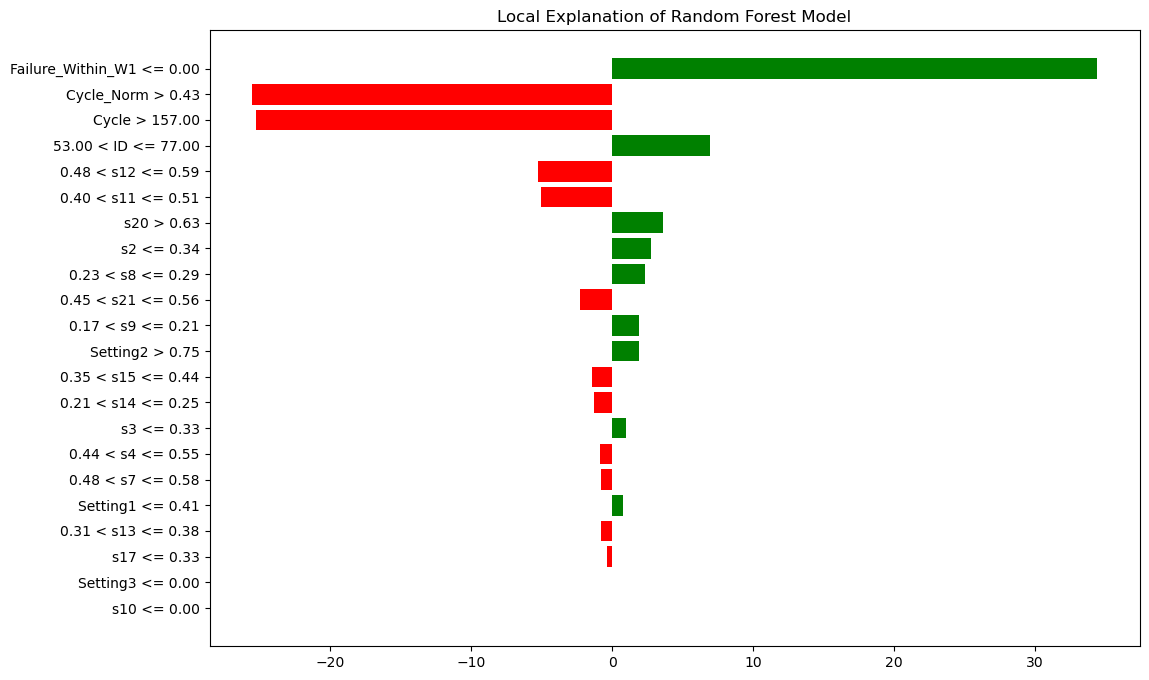

In [18]:
import lime
import lime.lime_tabular

# Define the predict function for Lime
predict_fn_tree = lambda x: regressor.predict(x).reshape(-1, 1)

# Define the explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns,
                                                   class_names=['RUL'],
                                                   verbose=True, 
                                                   mode='regression')

# Choose an instance to explain
instance = X_test.iloc[0]

# Generate the explanation for the instance using LIME
exp = explainer.explain_instance(instance.values,regressor.predict, num_features=len(X_train.columns))

# Get the explanation figure as a pyplot figure
fig = exp.as_pyplot_figure()
fig.set_size_inches(12, 8)  # Adjust the width and height as needed
plt.title('Local Explanation of Random Forest Model')
plt.show()

In [19]:
#Decision Tree
regressor = DecisionTreeRegressor(random_state=42, min_samples_split=2)

# Train the model
regressor.fit(X_train, y_train)
# Predict on the test set
y_pred = regressor.predict(X_test)
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

error_df.loc['Decision Tree Regression'] = [mae, mse, rmse, r2]

print(f"Mean Absolute Error =",mae)
print(f"Mean Squared Error =",mse)
print(f"Root Mean Squared Error =",rmse)
print(f"R2",r2)

Mean Absolute Error = 11.588320814150714
Mean Squared Error = 480.66707051126724
Root Mean Squared Error = 21.92412074659477
R2 0.8947934723718478


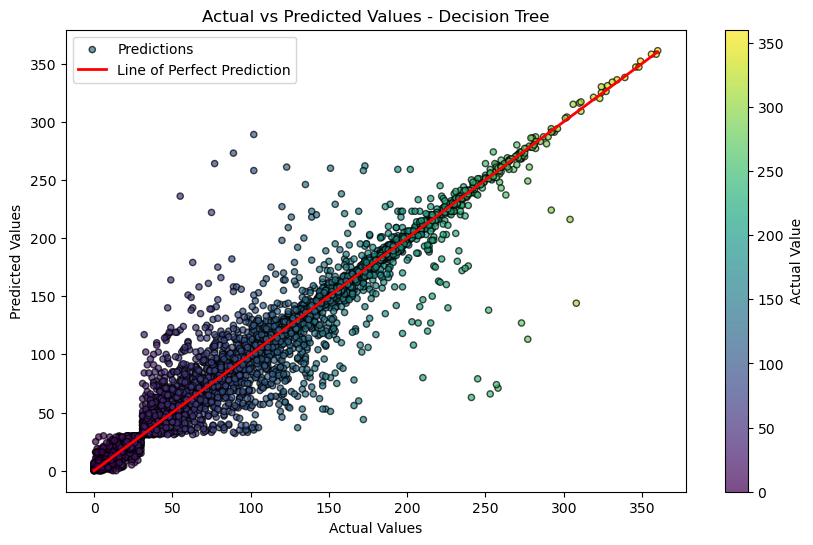

In [20]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(y_test, y_pred, c=y_test, cmap='viridis', marker='o', edgecolor='k', alpha=0.7, s=20, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label="Line of Perfect Prediction")
plt.colorbar(sc, label='Actual Value')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values - Decision Tree")
plt.legend()
plt.show()

/Users/ursulasalwa/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Intercept 93.23798289904849
Prediction_local [70.67669381]
Right: 110.0


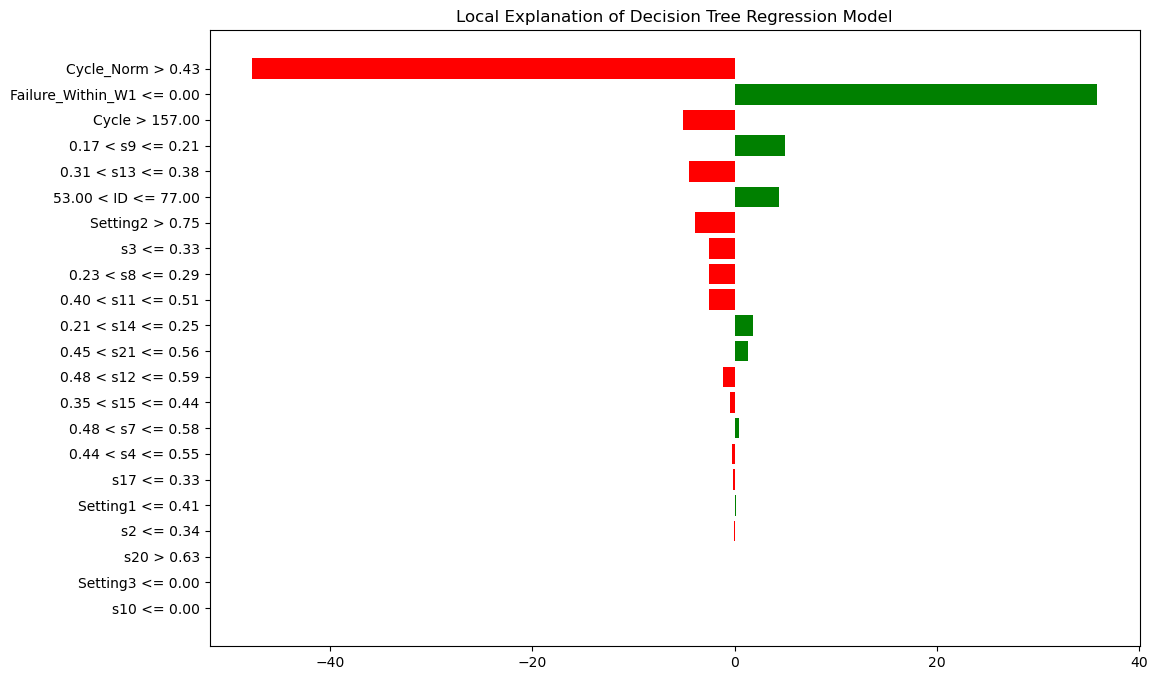

In [21]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns,
                                                   class_names=['RUL'],
                                                   verbose=True, 
                                                   mode='regression')

# Choose an instance to explain
instance = X_test.iloc[0]

# Generate the explanation for the instance using LIME
exp = explainer.explain_instance(instance.values,regressor.predict, num_features=len(X_train.columns))

# Get the explanation figure as a pyplot figure
fig = exp.as_pyplot_figure()
fig.set_size_inches(12, 8)  # Adjust the width and height as needed
plt.title('Local Explanation of Decision Tree Regression Model')
plt.show()

In [22]:
#XGBoost
regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

error_df.loc['XGBoost'] = [mae, mse, rmse, r2]

print(f"Mean Absolute Error =",mae)
print(f"Mean Squared Error =",mse)
print(f"Root Mean Squared Error =",rmse)
print(f"R2 =",r2)

Mean Absolute Error = 33.532940343473676
Mean Squared Error = 1824.6127252070883
Root Mean Squared Error = 42.715485777491615
R2 = 0.6006358861923218


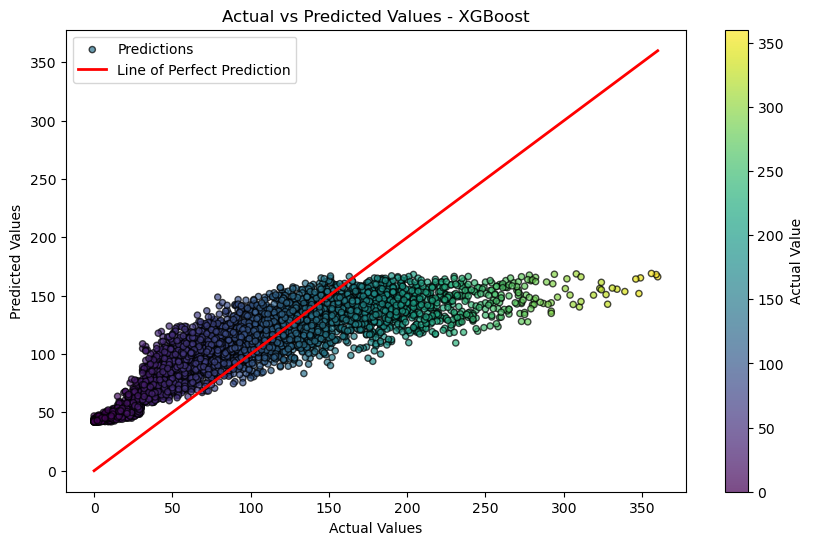

In [23]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(y_test, y_pred, c=y_test, cmap='viridis', marker='o', edgecolor='k', alpha=0.7, s=20, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label="Line of Perfect Prediction")
plt.colorbar(sc, label='Actual Value')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values - XGBoost")
plt.legend()
plt.show()

Intercept 98.01806240763784
Prediction_local [103.46815066]
Right: 111.65445


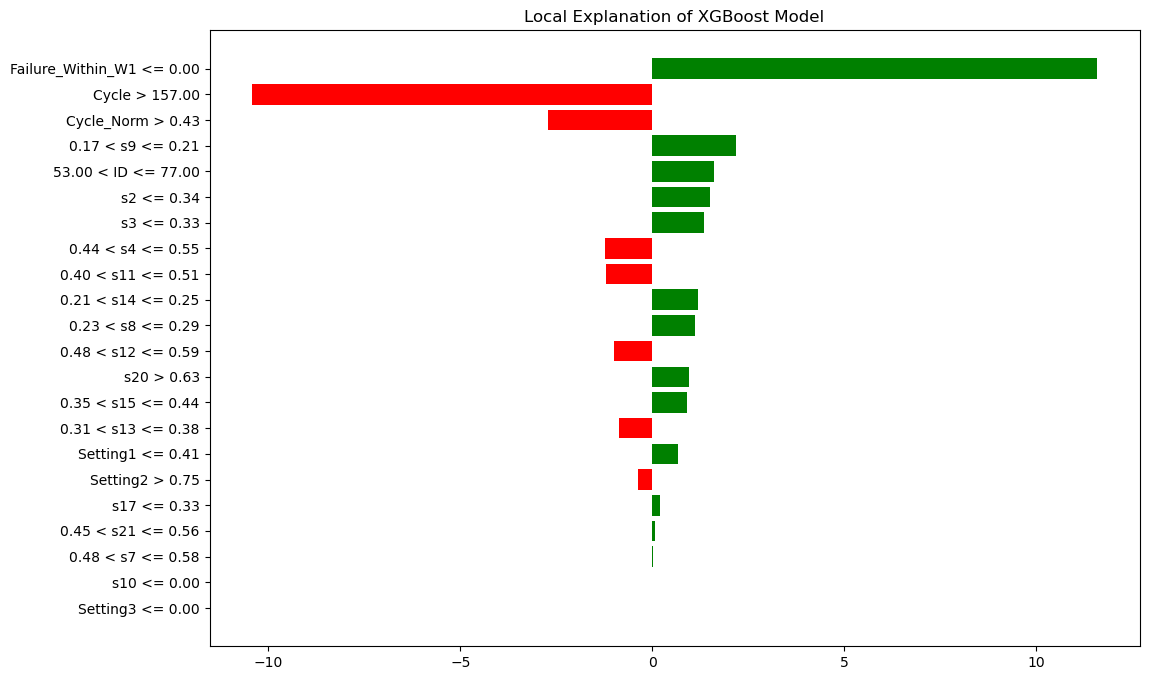

In [24]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns,
                                                   class_names=['RUL'],
                                                   verbose=True, 
                                                   mode='regression')

# Choose an instance to explain
instance = X_test.iloc[0]

# Generate the explanation for the instance using LIME
exp = explainer.explain_instance(instance.values,regressor.predict, num_features=len(X_train.columns))

# Get the explanation figure as a pyplot figure
fig = exp.as_pyplot_figure()
fig.set_size_inches(12, 8)  # Adjust the width and height as needed
plt.title('Local Explanation of XGBoost Model')
plt.show()

In [25]:
#SVR
regressor = SVR(kernel='rbf', C=100, gamma='auto')
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

error_df.loc['Support Vector Regression'] = [mae, mse, rmse, r2]

print(f"Mean Absolute Error =",mae)
print(f"Mean Squared Error =",mse)
print(f"Root Mean Squared Error =",rmse)
print(f"R2 =",r2)

Mean Absolute Error = 19.75096084423026
Mean Squared Error = 1169.6291085881446
Root Mean Squared Error = 34.19984076846184
R2 = 0.7439961572643548


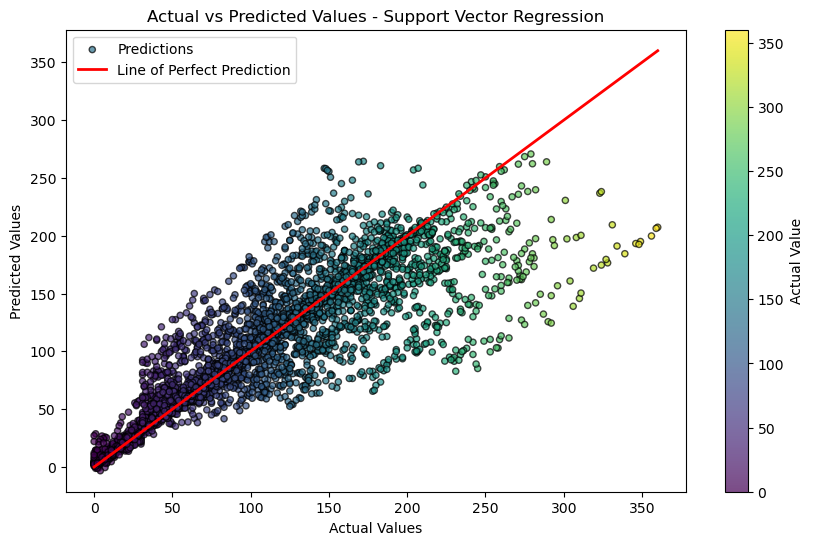

In [26]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(y_test, y_pred, c=y_test, cmap='viridis', marker='o', edgecolor='k', alpha=0.7, s=20, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label="Line of Perfect Prediction")
plt.colorbar(sc, label='Actual Value')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values - Support Vector Regression")
plt.legend()
plt.show()

/Users/ursulasalwa/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


Intercept 108.733308734797
Prediction_local [68.83844837]
Right: 133.33833325343264


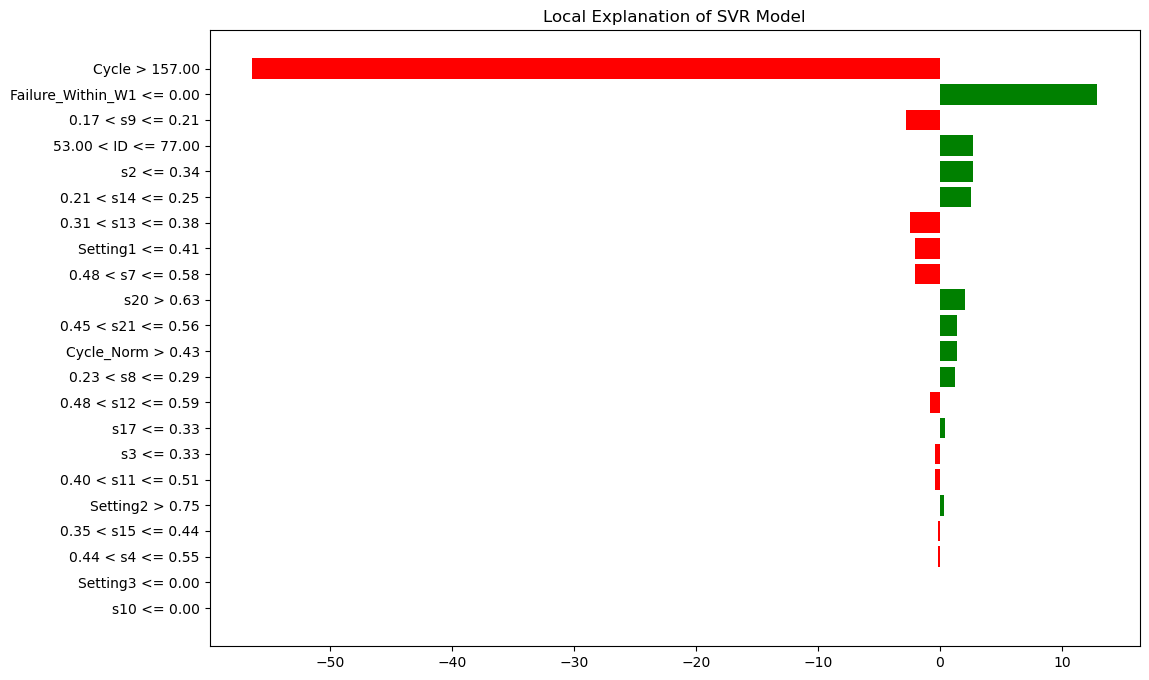

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns,
                                                   class_names=['RUL'],
                                                   verbose=True, 
                                                   mode='regression')

# Choose an instance to explain
instance = X_test.iloc[0]

# Generate the explanation for the instance using LIME
exp = explainer.explain_instance(instance.values,regressor.predict, num_features=len(X_train.columns))

# Get the explanation figure as a pyplot figure
fig = exp.as_pyplot_figure()
fig.set_size_inches(12, 8)  # Adjust the width and height as needed
plt.title('Local Explanation of SVR Model')
plt.show()

In [28]:
error_df

,MAE,MSE,RMSE,R2
Decision Tree Regression,11.588321,480.667071,21.924121,0.894793
Random Forest Regression,10.620417,259.442276,16.107212,0.943214
Support Vector Regression,19.750961,1169.629109,34.199841,0.743996
XGBoost,33.53294,1824.612725,42.715486,0.600636


## XAI